In [1]:
!nvidia-smi

Mon Sep 25 02:31:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:07:00.0  On |                  N/A |
| 38%   52C    P5    21W / 170W |    738MiB / 12288MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install segmentation-models-pytorch
!pip install -U albumentations
!pip install --upgrade opencv-contrib-python
!pip install mlflow --quiet

In [3]:
import sys
import os
import cv2
from PIL import Image

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

import torch 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, LovaszLoss,JaccardLoss, FocalLoss

from tqdm import tqdm
from datetime import datetime

import mlflow

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

import albumentations as A

## Download dataset

In [4]:
!apt install git -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.18).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [5]:
!git clone https://github.com/lucascsfaria/amazonwildroadsdataset.git

fatal: destination path 'amazonwildroadsdataset' already exists and is not an empty directory.


In [6]:
ls amazonwildroadsdataset

README.md  areas/  geojson_line/  image_geotif/  image_png/  mask/


## Parameters Initialization

In [7]:
DATA_DIR = "./amazonwildroadsdataset/"
MODELS_PATH = "./models/PRE/"
OUTPUT_DIR = "./output/PRE/"
DEVICE = 'cuda'

EPOCHS=1
LR=0.0003
IMAGE_SIZE= 128
BATCH_SIZE= 32

# Encoder to choose from ["timm-efficientnet-b0", "timm-efficientnet-b7", "resnext101_32x8d"]
ENCODER = 'timm-efficientnet-b7'
# Models to choose from ["DeepLabV3Plus","UnetPlusPlus","Unet"]
MODEL = "UnetPlusPlus"
# Weights to choose from ["imagenet","noisy-student"]
WEIGHTS = 'imagenet'

# Patch size
tam = 128
# Patch shift
stride = 64

## MLFlow Initialization

In [8]:
# Import the MLFlow package and select the path that will store the data files (If the folder does not exist, MLFlow will create the structures)
mlflow.set_tracking_uri("file:///user/home/Lucas/MLFlow2/")

In [9]:
# Creates an experiment with name "Pixel-wiseRoadExtraction" if it does not exist and returns the ID. If it already exists, returns the ID.
experiment = "Pixel-wiseRoadExtraction"

try:
    idExperiment = mlflow.create_experiment(experiment)
except:
    idExperiment = mlflow.get_experiment_by_name(experiment).experiment_id

## Augmentation Functions

In [10]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=.5),
      A.VerticalFlip(p=.5),
      A.Rotate()
  ])
def get_valid_augs():
    return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])

## Create Road Dataset Segmentation for Pixel-wise Road Extraction (PRE)

In [11]:
path_images_png = os.path.join(DATA_DIR, 'image_png')
path_mask_png = os.path.join(DATA_DIR, 'mask')

images_filenames = os.listdir(path_images_png)
images_mask_filenames = os.listdir(path_mask_png)

In [12]:
if len(images_filenames) != len(images_mask_filenames):
    print("Number of images does not correspond to the number of masks!")

In [13]:
dataset_images_crop = [] 

for filename in images_filenames:
    im = cv2.imread(os.path.join(path_images_png,filename))
    mask = Image.open(os.path.join(path_mask_png,filename)).convert('L')
    
    width, height = mask.size
    x_init = y_init = 0
    cont_part = 0
    
    print(filename)
   
    while x_init+tam<=width:
        y_init = 0
        while y_init+tam <=height:
            patch_image = im[y_init:y_init+tam, x_init:x_init+tam]
            patch_mask_ground_truth = mask.crop((x_init, y_init, x_init+tam, y_init+tam))
            
            np_img = np.array(patch_mask_ground_truth)
            np_non_zero = np.count_nonzero(np_img)

            if np_non_zero == 0:
                image_data = {
                    "label": 0,
                    "mask": np_img,
                    "image": patch_image,
                    "name_image": filename,
                    "coordinate": (x_init, y_init)
                }
            else:
                image_data = {
                    "label": 1,
                    "mask": np_img,
                    "image": patch_image,
                    "name_image": filename,
                    "coordinate": (x_init, y_init)
                }
            dataset_images_crop.append(image_data)
            cont_part+=1
            y_init+=stride
        x_init+=stride

PA1.png
PA2.png
PA5.png
PA12.png
MT1.png
RR2.png
MT3.png
AM4.png
AC2.png
PA11.png
AM2.png
PA10.png
AC1.png
RO1.png
PA7.png
PA9.png
AM1.png
AM6.png
PA3.png
PA8.png
RR1.png
AM5.png
TO1.png
AM7.png
MT2.png
AM3.png
PA4.png
PA6.png


In [14]:
class SegmentationDataset(Dataset):
  def __init__(self, list_images, augmentations):
    self.list_images = list_images
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.list_images)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
            idx = idx.tolist()
    

    image = self.list_images[idx]["image"]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = self.list_images[idx]["mask"]
    mask = np.expand_dims(mask, axis=-1)
    

    if self.augmentations:
      data = self.augmentations(image=image, mask= mask)
      image = data['image']
      mask = data['mask']

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image)/255.0
      mask = torch.round(torch.Tensor(mask)/255.0)

      return image,mask

In [15]:
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [16]:
train_filenames = ["PA1.png",
                   "PA8.png",
                   "PA5.png",
                   "PA12.png",
                   "MT1.png",
                   "RR2.png",
                   "MT3.png",
                   "AM4.png",
                   "PA11.png",
                   "AM2.png",
                   "PA10.png",
                   "PA7.png",
                   "AM1.png",
                   "PA3.png",
                   "RR1.png",
                   "AM5.png",
                   "TO1.png",
                   "MT2.png",
                   "PA4.png",
                   "PA6.png"]
test_filenames = ["AM3.png",
                  "AM7.png",
                  "AC1.png",
                  "AC2.png",
                  "AM6.png",
                  "RO1.png",
                  "PA2.png",
                  "PA9.png"]

In [17]:
# If you want to randomly separate between training and testing sets, uncomment this line
#train_filenames, test_filenames = train_test_split(images_filenames, test_size=0.2, random_state=3)

dataset_images = {}
dataset_images["train"] = [im for im in dataset_images_crop if im['name_image'] in train_filenames]
dataset_images["val"] = [im for im in dataset_images_crop if im['name_image'] in test_filenames]

In [18]:
trainset = SegmentationDataset(dataset_images["train"], get_train_augs())
validset = SegmentationDataset(dataset_images["val"], get_valid_augs())

In [19]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 12600
Size of Validset : 5040


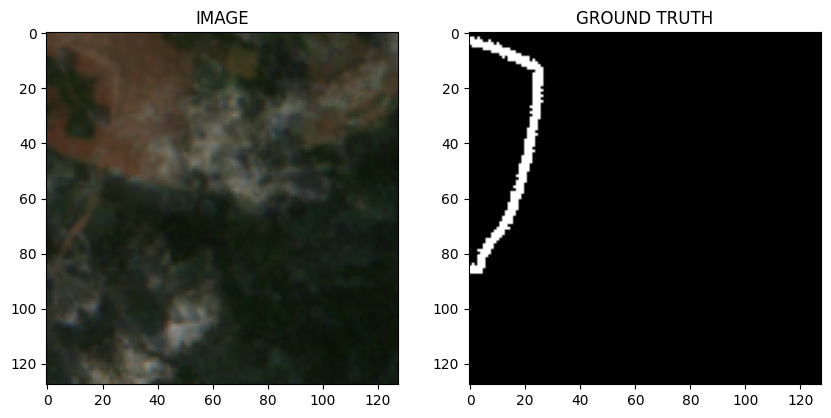

In [20]:
idx = 30

print(trainset)

image, mask = trainset[idx]
show_image(image,mask)

## Load dataset into batches

In [21]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [22]:
print(f"Total number of batches in train loader:  {len(trainloader)}")
print(f"Total number of batches in valid loader:  {len(validloader)}")

Total number of batches in train loader:  394
Total number of batches in valid loader:  158


In [23]:
for image,mask in trainloader:
  break

print(f"One Batch Image Shape: {image.shape}")
print(f"One Batch Mask Shape: {mask.shape}")

One Batch Image Shape: torch.Size([32, 3, 128, 128])
One Batch Mask Shape: torch.Size([32, 1, 128, 128])


## Create Segmentation Model

In [24]:
class SegmentationModel(nn.Module):

  def __init__(self, model = "DeepLabV3Plus"):
    super(SegmentationModel, self).__init__()

    if model == "DeepLabV3Plus":
        self.arc = smp.DeepLabV3Plus(
            encoder_name = ENCODER,
            encoder_weights= WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )
    if model == "Unet":
        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights= WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )
    if model == "UnetPlusPlus":
        self.arc = smp.UnetPlusPlus(
            encoder_name = ENCODER,
            encoder_weights= WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )

  def forward(self,images,masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = JaccardLoss(mode='binary')(logits,masks)
      loss2 = FocalLoss(mode='binary')(logits,masks)
      #loss2 = DiceLoss(mode='binary')(logits,masks)
      #loss3 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1+loss2#+loss3
    return logits

In [25]:
model = SegmentationModel(MODEL)
model.to(DEVICE)

SegmentationModel(
  (arc): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (bn1): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
 

## Create Train and Validation Function

In [26]:
def calc_metrics(tp, fp, fn, tn):
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
    f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
    balanced_accuracy  = smp.metrics.balanced_accuracy(tp, fp, fn, tn, reduction="micro")
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
    metrics = {'iou':iou_score,'f1_score':f1_score,'f2_score':f2_score,'accuracy':accuracy,'balanced_accuracy':balanced_accuracy,'recall':recall, 'precision': precision}
  
    return metrics

In [27]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0

  tp, fp, fn, tn = None,None,None,None

  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    labels = logits
    #labels = torch.argmax(logits, dim=1, keepdim=True)
    #labels = labels.long()


    tp_temp, fp_temp, fn_temp, tn_temp = smp.metrics.get_stats(labels.to(DEVICE), masks.long().to(DEVICE), mode='binary', threshold=0.5)
    
    if tp==None:
      tp = tp_temp
      fp = fp_temp
      fn = fn_temp
      tn = tn_temp
    else:
      tp = torch.cat([tp,tp_temp])
      fp = torch.cat([fp,fp_temp])
      fn = torch.cat([fn,fn_temp])
      tn = torch.cat([tn,tn_temp])
  
  d1 = calc_metrics(tp, fp, fn, tn)

  return total_loss/len(data_loader), d1

In [28]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0
  with torch.no_grad():

    tp, fp, fn, tn = None,None,None,None

    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images,masks)
      
      total_loss += loss.item()

      labels = logits
      #labels = torch.argmax(logits, dim=1, keepdim=True)
      #labels = labels.long()


      tp_temp, fp_temp, fn_temp, tn_temp = smp.metrics.get_stats(labels.to(DEVICE), masks.long().to(DEVICE), mode='binary', threshold=0.5)
    
      if tp==None:
        tp = tp_temp
        fp = fp_temp
        fn = fn_temp
        tn = tn_temp
      else:
        tp = torch.cat([tp,tp_temp])
        fp = torch.cat([fp,fp_temp])
        fn = torch.cat([fn,fn_temp])
        tn = torch.cat([tn,tn_temp])
  
  d1 = calc_metrics(tp, fp, fn, tn)

  return total_loss/len(data_loader), d1

## Train Model

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [30]:
best_iou = 0

if not os.path.isdir(MODELS_PATH):
    os.makedirs (MODELS_PATH)

with mlflow.start_run(experiment_id=idExperiment, run_name=ENCODER+"_"+MODEL):
  mlflow.log_param("EPOCHS", EPOCHS)
  mlflow.log_param("LR", LR)
  mlflow.log_param("IMAGE_SIZE", IMAGE_SIZE)
  mlflow.log_param("BATCH_SIZE", BATCH_SIZE)
  mlflow.log_param("ENCODER", ENCODER)
  mlflow.log_param("MODEL", MODEL)
  mlflow.log_param("WEIGHTS", WEIGHTS)
  #mlflow.log_param("DATASET", DATASET)

  for i in range(EPOCHS):
    train_loss, train_metrics = train_fn(trainloader, model, optimizer)
    valid_loss, valid_metrics = eval_fn(validloader,model)

    if valid_metrics["iou"].item() > best_iou:
      torch.save(model.state_dict(),os.path.join(MODELS_PATH, MODEL+"-"+ENCODER+"-"+'best_model.pt'))
      print("Saved Model")
      best_iou = valid_metrics["iou"].item()
    
    print(f"Epoch = {i+1} Train loss : {train_loss} Valid loss {valid_loss}")

    mlflow.log_metric("TRAIN_LOSS", train_loss, step=i)
    mlflow.log_metric("VALID_LOSS", valid_loss, step=i)

    for key in train_metrics:
      mlflow.log_metric("TRAIN_"+key, train_metrics[key].item(), step=i)
    
    for key in valid_metrics:
      print(key,": ",valid_metrics[key].item())
      mlflow.log_metric("VALID_"+key, valid_metrics[key].item(), step=i)
  
  torch.save(model.state_dict(),os.path.join(MODELS_PATH,MODEL+"-"+ENCODER+"-"+'final_model.pt'))
  print("Saved Final Model")

  mlflow.log_artifact(os.path.join(MODELS_PATH, MODEL+"-"+ENCODER+"-"+"best_model.pt"))
  mlflow.log_artifact(os.path.join(MODELS_PATH, MODEL+"-"+ENCODER+"-"+"final_model.pt"))

100%|██████████| 158/158 [00:21<00:00,  7.37it/s]


Saved Model
Epoch = 1 Train loss : 0.7928069806492268 Valid loss 0.3237774400424166
iou :  0.4486056864261627
f1_score :  0.6193620562553406
f2_score :  0.600399911403656
accuracy :  0.9954441785812378
balanced_accuracy :  0.7932076454162598
recall :  0.5883906483650208
precision :  0.6537750959396362
Saved Final Model


## Inference

In [31]:
idx = 150

model.load_state_dict(torch.load(os.path.join(MODELS_PATH, MODEL+"-"+ENCODER+"-"+'final_model.pt')))
model.eval()
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)

#pred_mask = (pred_mask>0.5)*1.0

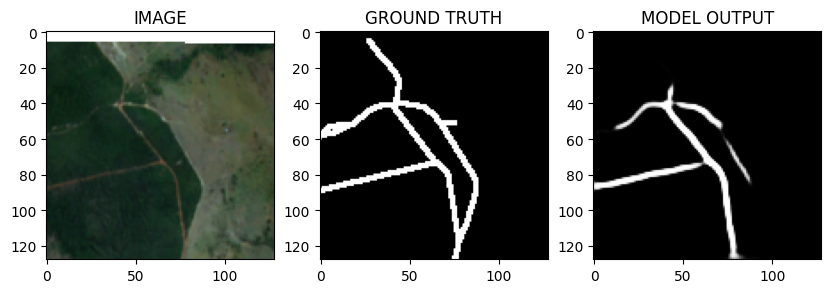

In [32]:
show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

In [33]:
def predict_patch(model_ft, image):
    model.eval()
    
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    image = torch.Tensor(image)/255.0
    
    logits_mask = model(image.to(DEVICE).unsqueeze(0))

    pred_mask = torch.sigmoid(logits_mask)
    
    return pred_mask

In [34]:
output_path_all_patches = os.path.join(OUTPUT_DIR, MODEL+"-"+ENCODER+"-"+WEIGHTS+"-"+"all_patches")
if not os.path.isdir(output_path_all_patches):
    os.makedirs (output_path_all_patches)

(1059, 2793)


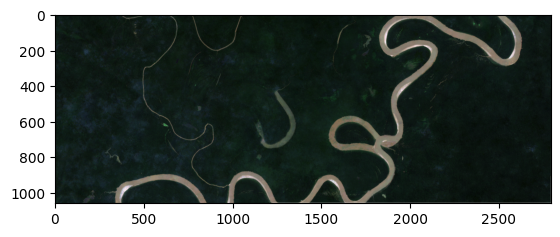

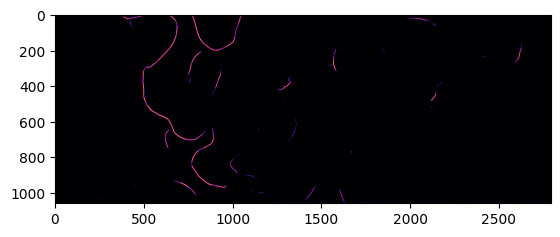

(1059, 2793)


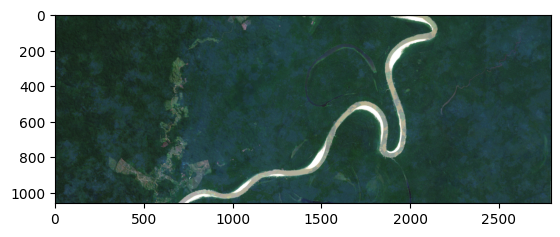

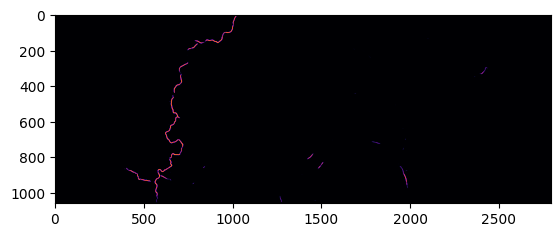

(1059, 2794)


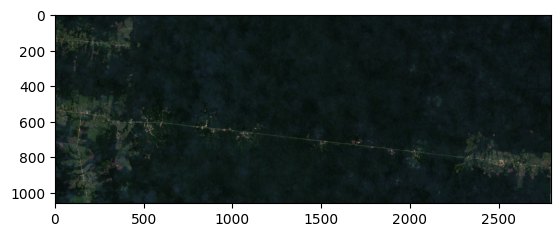

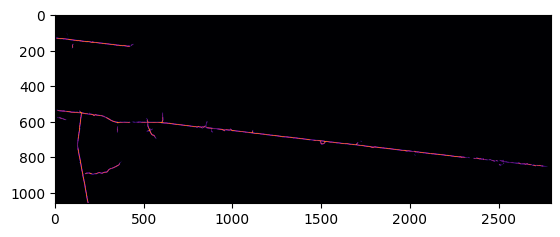

(1059, 2793)


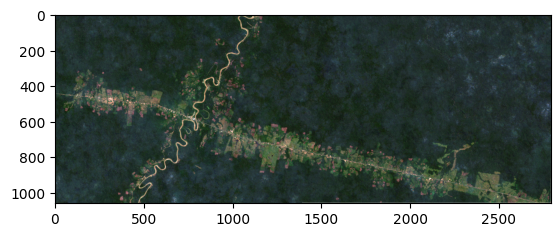

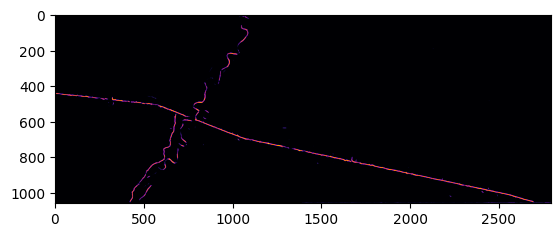

(1059, 2794)


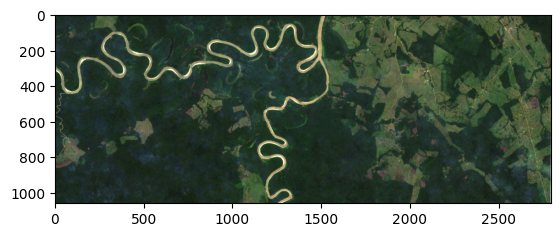

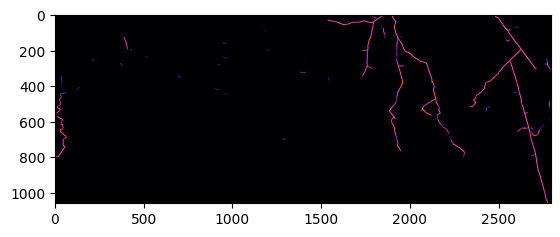

(1059, 2794)


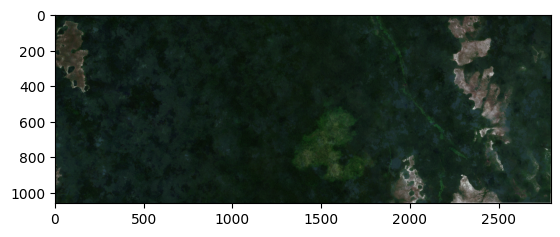

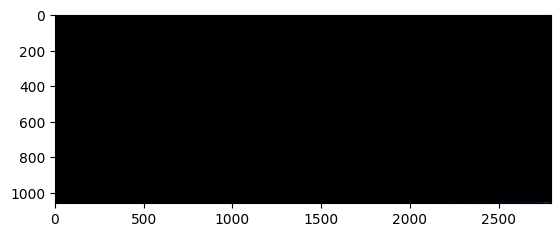

(1072, 2792)


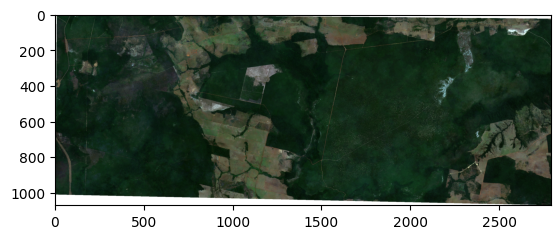

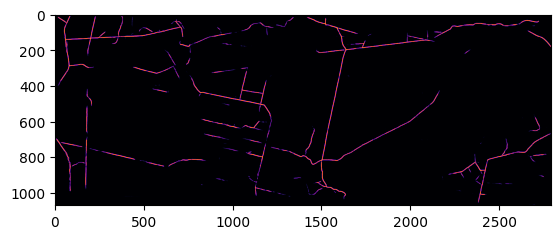

(1059, 2794)


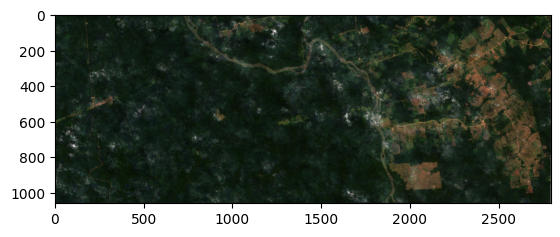

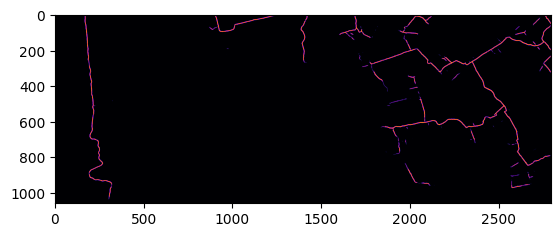

In [35]:
for image_filename in test_filenames:
    path_filename = os.path.join(DATA_DIR, os.path.join("image_png", image_filename))

    image = cv2.imread(path_filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    x_init = y_init = 0

    old_image_height, old_image_width, channels = image.shape
    
    image_padding = cv2.copyMakeBorder(image.copy(),tam,tam,tam,tam,cv2.BORDER_CONSTANT,value=[0,0,0])

    image_height, image_width, channels = image_padding.shape
    segmentation = np.zeros([image_height,image_width], dtype = np.float32)

    while x_init+tam<=image_width:
      y_init = 0
      while y_init+tam <=image_height:
        image_eval = image_padding[y_init:y_init+tam,x_init:x_init+tam]
        pred_mask = predict_patch(model, image_eval)
        segmentation[y_init:y_init+tam,x_init:x_init+tam] += pred_mask.cpu().detach().numpy()[0][0]
        y_init+=stride
      x_init+=stride

    segmentation = segmentation[tam: image_height-tam, tam: image_width-tam]
    print(segmentation.shape)
    plt.imshow(image)
    plt.show()
    plt.imshow(segmentation, cmap='inferno')
    plt.show()

    mask_gray = cv2.normalize(src=segmentation, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    
    mask_gray[mask_gray>=51] = 255
    mask_gray[mask_gray<51] = 0

    cv2.imwrite(os.path.join(output_path_all_patches,image_filename), mask_gray)


## Calculate Metrics

In [36]:
def calculate_metrics(TP, TN, FP, FN):
    
    sensitivity = TP / (TP + FN)
    
    specificity = TN / (TN + FP)
    
    accuracy = (TP + TN) / (TP+FN+FP+TN)
    
    recall= TP / (TP+FN)
    
    precision = TP/(TP + FP)
    
    baccuracy = (sensitivity + specificity) / 2
    
    IOU = TP / (TP + FP + FN)
    
    F1_score = 2 * ((precision * recall) / (precision + recall))
    

    metrics = {'iou': IOU, 'f1_score':F1_score,'accuracy':accuracy,'balanced_accuracy':baccuracy, 'precision': precision, 'recall': recall}
    return metrics

In [37]:
groundtruth_path = os.path.join(DATA_DIR, "mask")

In [38]:
tp = tn = fp = fn = 0

for filename in os.listdir(output_path_all_patches):

    mask = cv2.imread(os.path.join(output_path_all_patches, filename), cv2.IMREAD_GRAYSCALE)
    groundtruth = cv2.imread(os.path.join(groundtruth_path, filename),cv2.IMREAD_GRAYSCALE)

    tn_temp, fp_temp, fn_temp, tp_temp = confusion_matrix(groundtruth.flatten(), mask.flatten()).ravel()

    #tn_temp, fp_temp, fn_temp, tp_temp = np.float64(tn_temp), np.float64(fp_temp), np.float64(fn_temp), np.float64(tp_temp)

    tp += tp_temp
    tn += tn_temp
    fp += fp_temp
    fn += fn_temp

metrics = calculate_metrics(tp, tn, fp, fn)

In [39]:
filter_string = "attributes.run_name ILIKE '%"+ENCODER+"_"+MODEL+"%'"
df = mlflow.search_runs([idExperiment], filter_string=filter_string, order_by=["start_time DESC"])
print(df['run_id'][0])

with mlflow.start_run(run_id=df['run_id'][0]):
    
    for key in metrics:
        print(f"{key} : {metrics[key]}")
        mlflow.log_metric("TEST_"+key, metrics[key])

bcbae30987e34fc596e6195b984b720a
iou : 0.4611805691363808
f1_score : 0.6312437749003985
accuracy : 0.9950014701434311
balanced_accuracy : 0.8472154823466053
precision : 0.5764186926937965
recall : 0.6975942653118787
